In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import yfinance as yf
import pandas as pd

In [10]:
df = pd.read_csv("/kaggle/input/aapl-dummy/AAPL_Dummy.csv")
print(df.columns)
print(df.head())

Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
   Unnamed: 0        Open        High         Low       Close   Adj Close  \
0  2022-01-03  151.325358  151.912268  151.257972  151.795827  151.493428   
1  2022-01-04  152.002075  152.106188  151.614771  150.931547  151.716900   
2  2022-01-05  153.040357  154.747221  152.961209  154.413751  153.512277   
3  2022-01-06  157.275543  158.157692  157.019459  156.919474  157.058336   
4  2022-01-07  156.618152  157.627796  157.046758  156.725827  157.090030   

    Volume  
0  3323659  
1  3403215  
2  1764121  
3  3873817  
4  2739183  


In [11]:
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  151.325358  151.912268  151.257972  151.795827  151.493428   
2022-01-04  152.002075  152.106188  151.614771  150.931547  151.716900   
2022-01-05  153.040357  154.747221  152.961209  154.413751  153.512277   
2022-01-06  157.275543  158.157692  157.019459  156.919474  157.058336   
2022-01-07  156.618152  157.627796  157.046758  156.725827  157.090030   

             Volume  
Date                 
2022-01-03  3323659  
2022-01-04  3403215  
2022-01-05  1764121  
2022-01-06  3873817  
2022-01-07  2739183  


In [12]:
df["return"] = df["Adj Close"].pct_change()

df["ma5"] = df["Adj Close"].rolling(window=5).mean()
df["ma20"] = df["Adj Close"].rolling(window=20).mean()

df.dropna(inplace=True)

print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-28  152.376852  153.230714  152.518541  153.113354  153.148058   
2022-01-31  156.084462  156.770267  156.384502  155.390868  156.579355   
2022-02-01  156.578323  156.940777  156.469128  156.939882  156.627802   
2022-02-02  156.617537  158.457129  157.221237  158.532036  157.262859   
2022-02-03  153.312752  155.190544  154.357306  155.611100  154.913363   

             Volume    return         ma5        ma20  
Date                                                   
2022-01-28  3530526 -0.014952  155.651107  158.273787  
2022-01-31  3817929  0.022405  155.529802  158.528083  
2022-02-01  4693305  0.000309  155.723319  158.773628  
2022-02-02  4518098  0.004055  155.818148  158.961157  
2022-02-03  1887225 -0.014940  155.706287  158.853908  


In [13]:
import gym
from gym import spaces
import numpy as np

In [14]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(6,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            self.balance,
            self.shares_held,
            row["Adj Close"],
            row["ma5"],
            row["ma20"],
            row["return"]
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row["Adj Close"]
        prev_portfolio = self.balance + self.shares_held * price

        if action == 1 and self.balance >= price:
            self.balance -= price
            self.shares_held += 1
        elif action == 2 and self.shares_held > 0:
            self.balance += price
            self.shares_held -= 1

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        new_price = self.df.loc[self.current_step]["Adj Close"]
        new_portfolio = self.balance + self.shares_held * new_price
        reward = new_portfolio - prev_portfolio

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}")

In [16]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([lambda: StockTradingEnv(df)])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 851  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 631         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012845134 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00177     |
|    learning_rate        | 0.0003      |
|    loss                 | 8.96e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00863    |
|    value_loss           | 1.73e+04    |
-----------------------------------------
-----------------

In [17]:
env = StockTradingEnv(df)
obs = env.reset()
done = False
portfolio_values = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    current_price = env.df.loc[env.current_step]["Adj Close"]
    portfolio_value = env.balance + env.shares_held * current_price
    portfolio_values.append(portfolio_value)

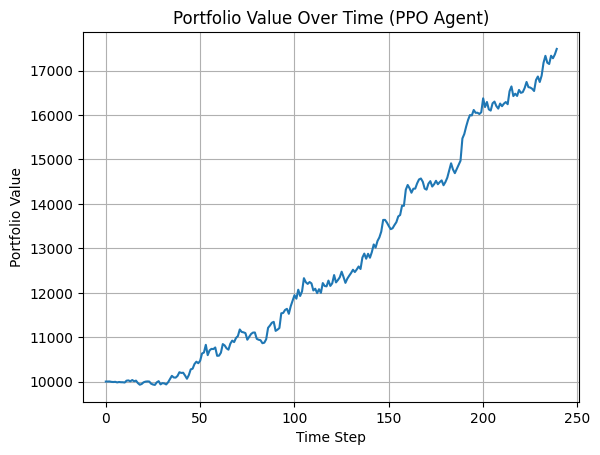

In [18]:
import matplotlib.pyplot as plt

plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time (PPO Agent)")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

In [19]:
env = StockTradingEnv(df)
obs = env.reset()
done = False
actions = []
prices = []
portfolio_values = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    price = env.df.loc[env.current_step]["Adj Close"]
    value = env.balance + env.shares_held * price

    actions.append(action)
    prices.append(price)
    portfolio_values.append(value)

action_labels = {0: "Hold", 1: "Buy", 2: "Sell"}

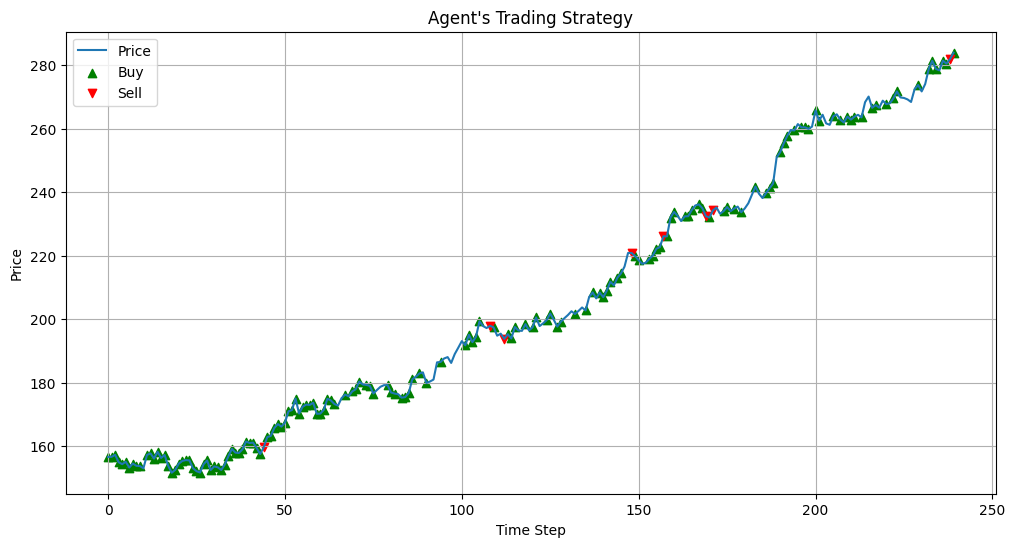

In [20]:
import matplotlib.pyplot as plt

buy_signals = [i for i, a in enumerate(actions) if a == 1]
sell_signals = [i for i, a in enumerate(actions) if a == 2]

plt.figure(figsize=(12, 6))
plt.plot(prices, label="Price")
plt.scatter(buy_signals, [prices[i] for i in buy_signals], label="Buy", marker="^", color="green")
plt.scatter(sell_signals, [prices[i] for i in sell_signals], label="Sell", marker="v", color="red")
plt.title("Agent's Trading Strategy")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()